In [ ]:
import sys

project_root = "/home/20230765/src"
if project_root not in sys.path:
    sys.path.append(project_root)
import json
import numpy as np
import torch
import h5py
from tqdm.notebook import tqdm
from redi.trajectory import retrieve_nearest_neigbours, generate_trajectory_from_latents
from redi.knowledge_base import create_kb
import seaborn as sns

import matplotlib.pyplot as plt
import faiss
import pickle
import time
import pandas as pd

### Distances distribution exploration

In [55]:
trajectory_path = "../data/generated_data/trajectories.h5"

num_trajectories = 2000

np.random.seed(42)
query_set = np.random.choice(np.arange(0, num_trajectories), size=200, replace=False)
key_set = list(set(np.arange(0, num_trajectories)) - set(query_set))
kb_path = "../data/reference_knowledge_base/knowledge_base.h5"
faiss_index_path = "../data/reference_knowledge_base/faiss_index.bin"
prompts_to_path = "../data/reference_knowledge_base/prompts.json"
key_margin_steps = 0

In [60]:
trajectory_path = "../data/generated_data/coco_trajectories.h5"

num_trajectories = 10000

np.random.seed(42)
query_set = np.random.choice(np.arange(0, num_trajectories), size=2000, replace=False)
key_set = list(set(np.arange(0, num_trajectories)) - set(query_set))
kb_path = "../data/reference_knowledge_base/coco_knowledge_base.h5"
faiss_index_path = "../data/reference_knowledge_base/coco_faiss_index.bin"
prompts_to_path = "../data/reference_knowledge_base/coco_prompts.json"
key_margin_steps = 0

In [47]:
with h5py.File(trajectory_path, "r") as trajectory_file:
    traj_names = list(trajectory_file.keys())
    reference_neighbours_list = []
    reference_distances_list = []
    reference_time = 0
    for query in tqdm(query_set):
        query = trajectory_file[traj_names[query]][key_margin_steps]
        neighbours, timing = retrieve_nearest_neigbours(
            query_array=query,
            num_neighbours=11,
            index_path=faiss_index_path,
            kb_path=kb_path,
        )

        reference_neighbours_list.append(
            [int(neighbour[2]) for neighbour in neighbours][1:]
        )
        reference_distances_list.append([neighbour[1] for neighbour in neighbours][1:])

  0%|          | 0/200 [00:00<?, ?it/s]

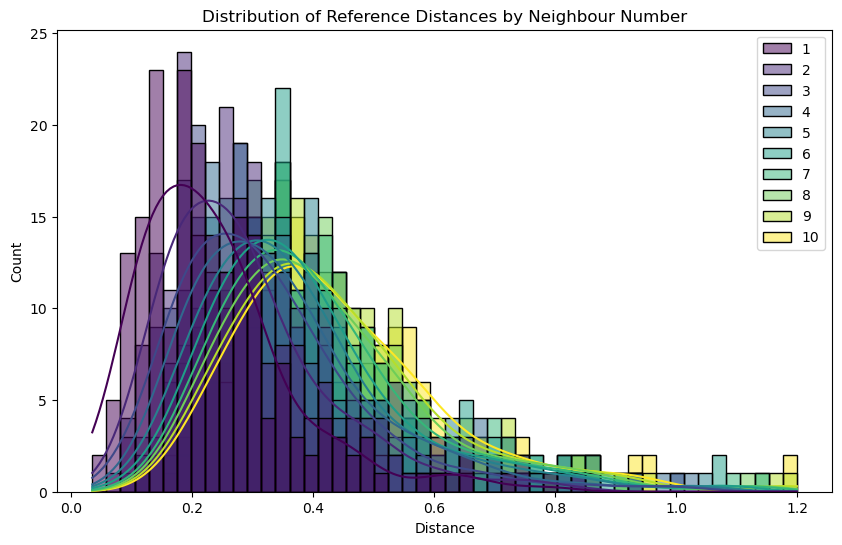

In [ ]:
flat_distances = [d for sublist in reference_distances_list for d in sublist]
flat_counts = [
    d
    for sublist in [
        np.arange(1, len(sublist) + 1) for sublist in reference_distances_list
    ]
    for d in sublist
]
max_neigh = max(flat_counts)

stats = []
for n in range(1, max_neigh + 1):
    dists = [
        flat_distances[i] for i in range(len(flat_distances)) if flat_counts[i] == n
    ]
    stats.append(
        {
            "neighbour": n,
            "mean": np.mean(dists),
            "median": np.median(dists),
            "std": np.std(dists),
        }
    )

df_stats = pd.DataFrame(stats)
df_stats.to_csv("../data/results/neighbour_distances_reference.csv", index=False)

plt.figure(figsize=(10, 6))
sns.histplot(
    x=flat_distances, hue=flat_counts, palette="viridis", bins=50, kde=True, legend=True
)
plt.xlabel("Distance")
plt.ylabel("Count")
plt.title("Distribution of Reference Distances by Neighbour Number")
plt.show()

In [62]:
config = [
    {
        "use_pca": True,
        "embedding_dim": 64,
        "use_pq": False,
    }
]

kb_path = "../data/knowledge_base/knowledge_base.h5"
faiss_index_path = "../data/knowledge_base/faiss_index.bin"
prompts_to_path = "../data/knowledge_base/prompts.json"

use_pca = True
pca_path = "../data/knowledge_base/compression.pkl"
prompts_from_path = "../data/generated_data/coco_prompts.jsonl"
value_margin_steps = 25
key_margin_steps = 0

dim_neighbours = []
dim_distances = []
avg_times = []
for cfg in tqdm(config):
    create_kb(
        key_margin_steps=key_margin_steps,
        value_margin_steps=value_margin_steps,
        trajectory_path=trajectory_path,
        kb_path=kb_path,
        faiss_index_path=faiss_index_path,
        prompts_from_path=prompts_from_path,
        prompts_to_path=prompts_to_path,
        pca_path=pca_path,
        **cfg,
    )
    # clean queries
    with h5py.File(kb_path, "a") as kb_file:
        for query in query_set:
            del kb_file[str(query)]

    # remove ids
    index = faiss.read_index(faiss_index_path)
    index.remove_ids(query_set)
    faiss.write_index(index, faiss_index_path)

    # find neigbours
    avg_times_list = []
    for i in range(1):
        neighbours_list = []
        distances_list = []
        timing = 0
        with h5py.File(trajectory_path, "r") as trajectory_file:
            traj_names = list(trajectory_file.keys())
            for query in tqdm(query_set):
                query = trajectory_file[traj_names[query]][key_margin_steps]
                if "use_pca" in cfg.keys() and cfg["use_pca"] == True:
                    pca = pickle.load(open(pca_path, "rb"))
                    start_pca = time.time()
                    query = pca.transform(query.reshape(1, -1)).squeeze()
                    end_pca = time.time()
                    elapsed_pca = end_pca - start_pca
                    timing += elapsed_pca
                neighbours, time_search = retrieve_nearest_neigbours(
                    query_array=query,
                    num_neighbours=10,
                    index_path=faiss_index_path,
                    kb_path=kb_path,
                )
                neighbours_list.append([int(neighbour[2]) for neighbour in neighbours])
                distances_list.append([neighbour[1] for neighbour in neighbours])
                timing += time_search
                # print(f"Query took {np.round(time_search, 5)} seconds")
        avg_times_list.append(timing / len(query_set))
        print(f"Avg time: {timing / len(query_set)}")
    avg_times.append(avg_times_list)
    dim_neighbours.append(neighbours_list)
    dim_distances.append(distances_list)

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting PCA...


10000it [00:28, 355.72it/s]


  0%|          | 0/2000 [00:00<?, ?it/s]

Avg time: 0.0005612579584121704


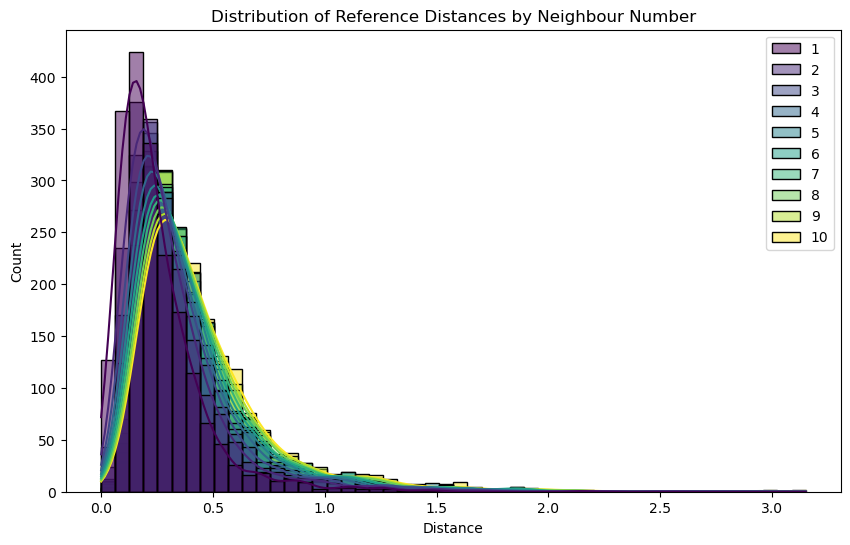

In [64]:
flat_distances = [d for sublist in distances_list for d in sublist]
flat_counts = [
    d
    for sublist in [np.arange(1, len(sublist) + 1) for sublist in distances_list]
    for d in sublist
]
max_neigh = max(flat_counts)

stats = []
for n in range(1, max_neigh + 1):
    dists = [
        flat_distances[i] for i in range(len(flat_distances)) if flat_counts[i] == n
    ]
    stats.append(
        {
            "neighbour": n,
            "mean": np.mean(dists),
            "median": np.median(dists),
            "std": np.std(dists),
            "25th_percentile": np.percentile(dists, 25),
            "75th_percentile": np.percentile(dists, 75),
        }
    )

df_stats = pd.DataFrame(stats)
df_stats.to_csv(
    "../data/results/adaptive_skipping/coco_neighbour_distances_pca=64.csv", index=False
)

plt.figure(figsize=(10, 6))
sns.histplot(
    x=flat_distances, hue=flat_counts, palette="viridis", bins=50, kde=True, legend=True
)
plt.xlabel("Distance")
plt.ylabel("Count")
plt.title("Distribution of Reference Distances by Neighbour Number")
plt.show()

### Adaptive skipping

In [66]:
coco_flg = True

In [ ]:
adaptive_skipping_config = [[23, 24]]

In [ ]:
num_queries = len(query_set)

clips_real = []
clips_generated = []
picks = []
inceptions_real = []
inceptions_generated = []
fids = []
if coco_flg == True:
    coco_picks = []
    neighbour_coco_picks = []
    coco_clips = []
    fids_coco = []
    fids_neighbour = []
    inceptions_coco = []

cnt = 0
for value_margin_steps in tqdm([20, 25, 27]):
    resulting_images = []
    pick = 0
    if coco_flg == True:
        pick_coco = 0
        pick_coco_neighbour = 0
    for query_index in tqdm(range(num_queries)):
        neighbours = dim_neighbours[config_index][query_index]
        with h5py.File(trajectory_path, "r") as trajectory_file:
            neighbour_latent = trajectory_file[traj_names[neighbours[neighbour_num]]][
                -value_margin_steps
            ]
            last_real_latent = trajectory_file[traj_names[query_set[query_index]]][-1]

        prompt = prompts[str(query_set[query_index])]

        img_real = pipe.decode_latent_to_image(
            latent=last_real_latent,
        )

        img_real_from_neighbour = generate_trajectory_from_latents(
            prompt=prompt,
            latent=neighbour_latent,
            device="cuda:1",
            num_inference_steps=30,
            value_margin_steps=value_margin_steps - 1,
            scheduler=DDIMScheduler,
            pipeline=pipe,
        )[0]
        coco_img = coco_images_dict[coco_prompt_to_image_id[prompt]].resize((512, 512))
        resulting_images.append([img_real_from_neighbour, img_real, coco_img])

        # metrics
        pick += pick_score(
            prompt=prompt,
            images=[img_real_from_neighbour, img_real],
        )[0]
        if coco_flg == True:
            pick_coco_neighbour += pick_score(
                prompt=prompt,
                images=[img_real_from_neighbour, coco_img],
            )[0]
            pick_coco += pick_score(
                prompt=prompt,
                images=[img_real, coco_img],
            )[0]
    real_images = [images[1] for images in resulting_images]
    generated_images = [images[0] for images in resulting_images]

    clip_real = clip_score(
        images=real_images,
        prompts=[prompts[str(query_set[i])] for i in range(num_queries)],
    )
    clip_generated = clip_score(
        images=generated_images,
        prompts=[prompts[str(query_set[i])] for i in range(num_queries)],
    )

    fid = fid_score(
        real_images=real_images[:num_queries],
        generated_images=generated_images[:num_queries],
    )

    inception_real = inception_score(images=real_images)
    inception_generated = inception_score(images=generated_images)

    print("FID gen vs retrieval: ", fid)
    print("Inception score real: ", inception_real)
    print("Inception score generated: ", inception_generated)
    print("CLIP score real: ", clip_real)
    print("CLIP score generated: ", clip_generated)
    print("Pick score: ", pick / (query_index + 1))

    fids.append(fid)
    inceptions_real.append(inception_real)
    inceptions_generated.append(inception_generated)
    clips_real.append(clip_real)
    clips_generated.append(clip_generated)
    picks.append(pick / (query_index + 1))

    if coco_flg == True:
        coco_images = [images[2] for images in resulting_images]
        clip_coco = clip_score(
            images=coco_images,
            prompts=[prompts[str(query_set[i])] for i in range(num_queries)],
        )
        fid_coco = fid_score(
            real_images=coco_images,
            generated_images=real_images[:num_queries],
        )
        fid_neighbour = fid_score(
            real_images=coco_images,
            generated_images=generated_images[:num_queries],
        )
        inception_coco = inception_score(images=coco_images)
        print("FID gen vs coco: ", fid_coco)
        print("FID retrieval vs coco: ", fid_neighbour)
        print("Inception score coco: ", inception_coco)
        print("CLIP score coco: ", clip_coco)
        print("Pick score gen vs coco: ", pick_coco / (query_index + 1))
        print("Pick score retrieval vs coco: ", pick_coco_neighbour / (query_index + 1))
        fids_coco.append(fid_coco)
        fids_neighbour.append(fid_neighbour)
        inceptions_coco.append(inception_coco)
        coco_clips.append(clip_coco)
        coco_picks.append(pick_coco / (query_index + 1))
        neighbour_coco_picks.append(pick_coco_neighbour / (query_index + 1))

In [ ]:
prompts_to_path = "../data/reference_knowledge_base/prompts.json"
prompts = json.load(open(prompts_to_path, "r"))

In [ ]:
pipe = ReSDPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16
).to("cuda:0")

In [4]:
with open("../data/results/coco-neighbours_key-margin=0_dataset-size=10000.json") as f:
    dim_neighbours = json.load(f)

In [5]:
dim_neighbours

[[[3968, 5528, 4125, 1389, 9034, 8120, 1567, 3991, 2975, 7073],
  [2854, 8261, 6229, 5296, 5567, 4646, 6267, 250, 5847, 6878],
  [2778, 6957, 3661, 6609, 7804, 4913, 2395, 9779, 7497, 4212],
  [3747, 8906, 2937, 6493, 8359, 9561, 9291, 2597, 4497, 3190],
  [9694, 3627, 1266, 5453, 2185, 4224, 8307, 1333, 7652, 6138],
  [7344, 609, 6931, 6873, 4886, 9188, 7197, 656, 3788, 876],
  [293, 7312, 7309, 9845, 2599, 3697, 3575, 8389, 2438, 5388],
  [9255, 910, 5058, 1288, 1827, 3691, 5479, 7384, 9422, 5594],
  [4179, 9880, 6778, 1647, 6422, 6057, 7884, 2789, 9537, 4143],
  [4273, 2890, 6696, 6036, 2950, 1323, 909, 4610, 8041, 6896],
  [806, 4233, 5271, 8789, 9836, 5763, 7179, 183, 6030, 8524],
  [6138, 2185, 2105, 3941, 7473, 5380, 3627, 170, 7255, 4633],
  [1856, 7004, 8986, 6867, 9801, 3339, 4490, 5362, 9557, 9781],
  [8435, 9511, 5367, 1502, 1172, 3978, 7844, 4617, 5618, 3672],
  [3830, 6729, 1634, 4910, 4420, 6567, 1192, 5464, 8003, 552],
  [9949, 9513, 8863, 5252, 3895, 3806, 7581, 9327, 

In [ ]:
with h5py.File(trajectory_path, "r") as trajectory_file:
    traj_names = list(trajectory_file.keys())